### Denoiser

1. Purpose

- Cleaning audio files, on the fly, to enhace the quality of the ASR process

2. What this should be: a very efficient network architecture, trained on random audio sources + garbage noise 🐳


The problem is modeled as a classical transfer learning problem:
```latex
\math{X} - generated dataset 
\math{Y} - real audio data
```

In [1]:
try:
    import torchaudio
except ImportError:
    %pip install torchaudio

In [2]:
import os

import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import numpy as np
import IPython
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Currently running on: {device}")
print(f"Current audio backends: {torchaudio.list_audio_backends()}")
print(f"Current datasets: {torchaudio.datasets.__all__}")

Currently running on: cpu
Current audio backends: ['soundfile', 'sox_io']
Current datasets: ['COMMONVOICE', 'LIBRISPEECH', 'SPEECHCOMMANDS', 'VCTK', 'VCTK_092', 'YESNO', 'LJSPEECH', 'GTZAN', 'CMUARCTIC', 'CMUDict', 'LibriMix', 'LIBRITTS', 'diskcache_iterator', 'bg_iterator', 'TEDLIUM']


### The main source for this playground will be common voice

In [3]:
if not os.path.exists("audio"):
    os.mkdir("audio")

def plot_specgram(waveform: torch.Tensor, sample_rate: float, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()

def add_noise_ratio(waveform: torch.Tensor, noise_ratio: float = 0.1) -> torch.Tensor:
    """
    Adds a specific ratio of noise to an audio signal.

    Args:
        waveform: The input audio waveform as a PyTorch tensor.
        noise_ratio: The ratio of noise to add to the signal (0.0 to 1.0).

    Returns:
        The noisy audio waveform as a PyTorch tensor.
    """

    noise = torch.randn_like(waveform)
    noisy_waveform = waveform + noise_ratio * noise
    return noisy_waveform

def noise(waveform: torch.Tensor) -> torch.Tensor:
    noise = torch.randn_like(waveform)
    assert noise.shape == waveform.shape, "The generated noise has differet size"
    return noise

In [4]:
dataset = torchaudio.datasets.YESNO(
    root="./audio",
    download=True
)

dataset

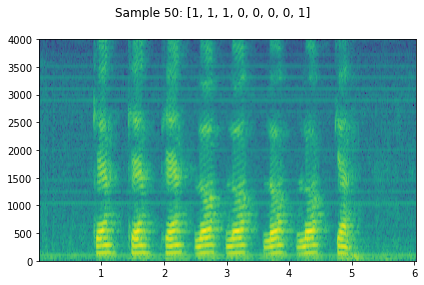

In [5]:
i = 50
waveform, sample_rate, label = dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

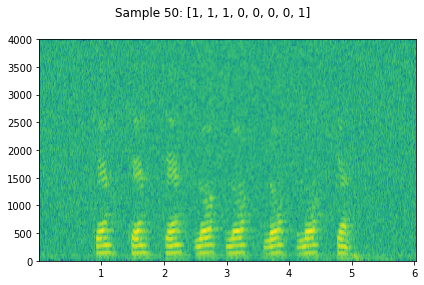

In [6]:
# Apply some noise to a part of the dataset
waveform, sample_rate, label = dataset[i]
noisy_waveform = add_noise_ratio(waveform=waveform, noise_ratio=0.01)
plot_specgram(noisy_waveform, sample_rate, title=f"Sample {i}: {label}")
IPython.display.Audio(noisy_waveform, rate=sample_rate)


### A simple asr benchmarking for the yes/no dataset

- use a pretrained net from torchaudio and evalute the accuracy on noisy and clean data
- create a denoiser: filter, network
- repeat

In [ ]:
try:
    import jiwer
except ImportError:
    %pip install jiwer